# How to apply the Kelly Criterion for portfolio optimization in Python

The Kelly Criterion is a well-known betting strategy, which maximizes expected return with the constraint that asymptotic probability of ruin (loss of all wealth) is zero. In this article, we are going to apply this strategy to BIST 30 stocks with weekly re-balancing and measure the ~2.5 year out of sample performance against the official index.

We introduce a portfolio consisting of $k$ assets where allocation fraction to any asset $i$ is equal to $f_i$. Then, our portfolio return for a single time interval is:

$r_P = (r + f^T (\mu - \large\mathbb{1} \normalsize r))$

where,

$r_P:$ Portfolio expected return

$r:$ The risk-free rate, where we are going to use **TLREF** rates

$f:$ Allocation weights vector, of shape (k, 1) where k is the number of assets, to be optimized later

$\mu:$ Mean returns vector, of shape (k, 1), to be calculated from data

$\large\mathbb{1} \normalsize :$ A vector of 1's, of shape (k, 1)

Thus, the term $(\mu - \large\mathbb{1} \normalsize r)$ is the **excess returns** vector of $k$ assets and it is weighted by the allocations vector $f$ to result in the expected return of the portfolio. We would like to maximize the $r_P$ value. However, if we only considered this term for the optimization process we would have no control over the portfolio variance. Our goal is to maximize the expected **Sharpe Ratio** of our portfolio, which is equal to:

$\text{SR}_P = \Large\frac{r_P - r}{\sigma_P^2} \normalsize = \Large\frac{f^T (\mu - \large\mathbb{1} \normalsize r)}{\sqrt{f^T \Sigma f}} $

where,

$\text{SR}_P:$ Sharpe ratio of the portfolio

$\Sigma:$ Covariance matrix of the assets in the portfolio, of shape (k, k)

$\sigma_P^2 = f^T \Sigma f:$ Variance of the portfolio

Moreover, portfolio optimization problems are usually constrained with no short-selling and no leverage conditions, to get more applicable results. Thus, we re-formulate our optimization problem in the following way, which accounts for both the maximization of portfolio expected return and minimization of portfolio variance as well as the necessary constraints:

$max_f \quad (r + f^T (\mu - \large\mathbb{1} \normalsize r) - \large\frac{f^T \Sigma f}{2}) $

with constraints:

$\sum\limits_{i=1}^{N} f_i \le 1: \qquad$ allocation weights for $N$ assets should be less than 1, no leverage is allowed. $(1-\sum\limits_{i=1}^{N} f_i)$ fraction of allocations is invested into the risk-free rate $r$

$0 \le f_i \le 1: \qquad$ any allocation weight should be between 0 and 1, no short-selling is allowed.

After we designed our optimization objective and necessary constraints, we move on to the programming part:

First, we download 1000 calendar days of Close price data for the BIST30 stocks using the **yfinance** library.

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.optimize import minimize
import datetime as dt
import matplotlib.pyplot as plt

tickers = [
    "AEFES", "AKBNK", "ASELS", "ASTOR", "BIMAS", "CIMSA", "EKGYO", "ENKAI",
    "EREGL", "FROTO", "GARAN", "GUBRF", "ISCTR", "KCHOL", "KOZAL", "KRDMD",
    "MGROS", "PETKM", "PGSUS", "SAHOL", "SASA", "SISE", "TAVHL", "TCELL",
    "THYAO", "TOASO", "TTKOM", "TUPRS", "ULKER", "YKBNK"
]

BIST_suffix = ".IS"  # add the BIST suffix for yfinance

tickers = [ticker + BIST_suffix for ticker in tickers]

end_date = dt.date(2025, 8, 1)
days_delta = dt.timedelta(days=1000)
start_date = end_date - days_delta

price_data = yf.download(tickers=tickers, start=start_date, end=end_date, interval="1d")["Close"].dropna()
print()
print("Price Data shape:", price_data.shape)
(price_data.iloc[:5, :5])  # Show the first 5x5 slice

/tmp/ipython-input-1266123510.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers=tickers, start=start_date, end=end_date, interval="1d")["Close"].dropna()
[*********************100%***********************]  30 of 30 completed



Price Data shape: (629, 30)


Ticker,AEFES.IS,AKBNK.IS,ASELS.IS,ASTOR.IS,BIMAS.IS
Date,,,,,
2023-01-18,5.535880,14.763786,31.414104,13.237703,127.910118
2023-01-19,5.569576,14.959391,30.741478,14.556661,128.766663
2023-01-20,5.579204,15.911891,31.115160,16.010401,128.766663
2023-01-23,5.458859,15.792828,30.342888,17.608553,130.479752
2023-01-24,5.401093,15.571712,31.389193,19.351116,130.289398


Then, we load the **TLREF** .xlsx file into pandas, and prepare it to calculate risk-free interval returns :

In [8]:

tlref_data

/tmp/ipython-input-3181330800.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tlref_data = yf.download(tickers=['TRY'], start=start_date, end=end_date, interval="1d")["Close"].dropna()
[*********************100%***********************]  1 of 1 completed


Ticker,TRY
Date,
2022-11-07,321.015137
2022-11-08,321.015137
2022-11-09,322.512909
2022-11-10,339.487244
2022-11-11,346.476685
...,...
2025-07-25,330.000000
2025-07-28,327.000000
2025-07-29,324.000000


In [20]:
from pathlib import Path

def read_excel(filename):
    script_folder = Path().resolve()
    filepath = str(script_folder) + filename
    data = pd.read_excel(filepath, index_col="Date")
    return data

# Read excel file
# tlref_data = read_excel(r"\TLREFORANI_D.xlsx")
tlref_data = yf.download(tickers=['TRY'], start=start_date, end=end_date, interval="1d")["Close"].dropna()
# clean dates
dates = tlref_data.index
dates = [date for date in dates if date in price_data.index]
tlref_data = tlref_data.loc[dates, :]

# Calculate stock returns
returns_data = price_data.pct_change().shift(-1).dropna()

# calculate calendar days between each business day
daycounts = (tlref_data.index[1:] - tlref_data.index[:-1]).days.to_numpy()

tlref_data = tlref_data.iloc[:-1, :]  # omit last day to align with daycounts shape

tlref_data.loc[:, "r"] = tlref_data.to_numpy().squeeze()/100 * daycounts/365
# Merge the dataframes
merged_df = pd.merge(returns_data, tlref_data.loc[:, "r"], how="inner", left_index=True, right_index=True)
merged_df.iloc[-5:, -5:]  # show the last 5x5 slice

/tmp/ipython-input-23107216.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tlref_data = yf.download(tickers=['TRY'], start=start_date, end=end_date, interval="1d")["Close"].dropna()
[*********************100%***********************]  1 of 1 completed

[1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 7 1 1 4 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1
 3 1 1 1 1 3 1 1 1 1 3 1 1 1 4 1 1 1 1 3 1 1 1 4 1 1 1 1 4 1 1 1 3 1 1 1 1
 3 1 1 1 4 1 1 1 1 4 1 1 1 3 1 1 1 1 3 1 1 1 1 4 1 1 1 3 1 6 2 1 1 3 1 1 1
 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 2 1 4 1
 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1
 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 2 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1
 1 1 4 1 1 1 4 1 1 1 3 1 1 1 1 4 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1
 1 1 4 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 4 1 1 1 1 3 7
 1 1 1 1 3 2 1 1 3 1 2 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 4 1 1 1 3 1 1 1 1 3
 1 1 1 1 6 1 3 1 1 1 1 3 1 1 2 3 1 1 1 1 4 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1
 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 5 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1
 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 2 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1
 3 1 1 2 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 2 1 3 1 2 1 3 1 1 2 3 1 1 1 1 4
 1 1 1 3 1 1 1 1 3 1 1 1 

,TTKOM.IS,TUPRS.IS,ULKER.IS,YKBNK.IS,r
Date,,,,,
2025-07-24,-0.014821,0.002400,-0.015668,-0.002397,0.009123
2025-07-25,-0.019469,-0.015560,-0.004682,-0.019820,0.027123
2025-07-28,-0.027978,-0.011550,0.028222,0.006740,0.008959
2025-07-29,0.010214,0.014760,0.016468,0.021303,0.008877
2025-07-30,0.000919,0.023636,-0.013501,0.002980,0.008904


After our datasets are prepared, we can begin the calculations. We are going to use monthly intervals to calculate rolling returns and covariances. So, our first mean vector will be the average of the January 2023 of daily asset returns, then the average of February 2023, and so on. This also applies to the rolling covariance matrix as well. After we calculate our rolling monthly means and covariances, we'll get an optimized allocation vector $f^*$ for the beginning of the next month.

The mean of daily returns $\mu$ for each month:

In [ ]:
mu_array_with_r = merged_df.resample("ME").mean()
print("The mean of daily returns for each month (including r):")
print("mu_array_with_r.shape:", mu_array_with_r.shape)
print(mu_array_with_r.iloc[-5:, -5:])  # show last 5x5 slice

The mean of daily returns for each month (including r):
mu_array_with_r.shape: (31, 31)
            TTKOM.IS  TUPRS.IS  ULKER.IS  YKBNK.IS         r
Date                                                        
2025-03-31  0.000494  0.005466  0.001688 -0.011733  0.001814
2025-04-30  0.005423 -0.003873 -0.002820 -0.001963  0.001948
2025-05-31  0.001720 -0.000177 -0.001232  0.005962  0.002075
2025-06-30  0.006051  0.007653  0.005159  0.011697  0.001990
2025-07-31 -0.005702  0.007874  0.001985  0.002596  0.001801


We also create an asset covariance matrix $\Sigma$ for each month and store them in a dictionary with the last date as its key:

In [ ]:
# group by each year+month, then compute .cov() on the returns in that bucket
cov_array = {
    period: group.cov()
    for period, group in merged_df.iloc[:, :-1].groupby(pd.Grouper(freq="ME"))  # omit the risk-free rate from covariance calculations
}
last_date = mu_array_with_r.index[-1]
print("Covariance matrix shape:", cov_array[last_date].shape)

Covariance matrix shape: (30, 30)


Finally, for each month-end data we have here, we are going to calculate the optimal allocation vector $f$. Then, we'll store them inside a dataframe. Let's remember our objective function to be maximized:

$(r + f^T (\mu - \large\mathbb{1} \normalsize r) - \large\frac{f^T \Sigma f}{2})$

Because we are going to use the SciPy minimize function, it is effectively the same problem to minimize the negative of the above function. So, our final objective function will be:

$g(f) = -(r + f^T (\mu - \large\mathbb{1} \normalsize r) - \large\frac{f^T \Sigma f}{2})$

where we have a quadratic optimization problem in $f$ to maximize function $g(.)$ with constraints

* $\sum\limits_{i=1}^{N} f_i \le 1$

* $0 \le f_i \le 1$

We are going to use the SciPy minimize method and call the **Sequential Least Squares Programming (SLSQP)** algorithm for the numerical optimization procedure:

In [ ]:
def calc_optimum_allocations(mu_array_with_r, cov_array):
    k = merged_df.iloc[:, :-1].shape[1]  # omit the risk-free rate, calculate asset count
    print("k =", k)

    # Assign initial value for f
    f_init = np.array([1 / k for _ in range(k)])
    f_optimum_dict = {}

    for date in mu_array_with_r.index:
        r = mu_array_with_r.loc[date, "r"]
        mu = mu_array_with_r.loc[date, :].iloc[:-1]
        Sigma = cov_array[date]

        # objective: negative of growth‐rate approx.
        def g(f):
            ones = np.ones(k)
            f_col = f[:, np.newaxis]
            return -(r + f.dot(mu - r * ones) - 0.5 * (f_col.T @ Sigma @ f_col))

        # constraints and bounds
        cons = {"type": "ineq", "fun": lambda f: 1 - f.sum()}
        bnds = tuple((0, 1) for _ in f_init)

        # optimize
        res = minimize(g, f_init, method="SLSQP", bounds=bnds, constraints=cons, tol=1e-12)
        f_optimum = np.round(res.x, 4)

        f_optimum_dict[date] = f_optimum

    f_optimum_df = pd.DataFrame(f_optimum_dict).T
    return f_optimum_df


f_optimum_df = calc_optimum_allocations(
    mu_array_with_r=mu_array_with_r,
    cov_array=cov_array
)
print("f_optimum_df.shape:", f_optimum_df.shape)
print(f_optimum_df.iloc[:5, :5])  # show the first 5×5 slice


k = 30
f_optimum_df.shape: (31, 30)
              0    1    2      3    4
2023-01-31  0.0  0.0  0.0  1.000  0.0
2023-02-28  0.0  0.0  0.0  1.000  0.0
2023-03-31  0.0  0.0  0.0  0.446  0.0
2023-04-30  0.0  0.0  0.0  0.000  0.0
2023-05-31  0.0  0.0  0.0  0.000  0.0


After optimizing for the allocations, we check for the shape of the optimum $f$ matrix and we see that it makes sense. We have 31 months and 30 assets. So each row of the resulting matrix is the optimal asset allocation for a specific month. This optimum $f$ vector is called "Full Kelly" fraction, because we use the optimum vector as it is. But in practice, there are also other possible criterions used in portfolio management, such as "Half Kelly" (less risk taking) or "Double Kelly" (more risk taking). Let's define these new criterions as well:

In [ ]:
# Half Kelly optimum f dataframe
f_optimum_df_half_kelly = f_optimum_df / 2.0

# Double Kelly optimum f dataframe
f_optimum_df_double_kelly = f_optimum_df * 2.0

Now we move on to backtest our optimum allocations to see how it performs against the BIST30 benchmark:

In [ ]:
# Download and calculate returns for BIST30 index
bist30_data = yf.download("XU030.IS", start=start_date, end=end_date)["Close"]
bist30_returns = bist30_data.loc[merged_df.index[0]:merged_df.index[-1], :].pct_change().shift(-1).dropna()
bist30_returns.columns = ["XU30 returns"]
bist30_returns.head()

C:\Users\Atakan\AppData\Local\Temp\ipykernel_22056\3378377394.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bist30_data = yf.download("XU030.IS", start=start_date, end=end_date)["Close"]
[*********************100%***********************]  1 of 1 completed


,XU30 returns
Date,
2023-01-18,0.010236
2023-01-19,0.015795
2023-01-20,-0.013978
2023-01-23,-0.005805
2023-01-24,-0.011238


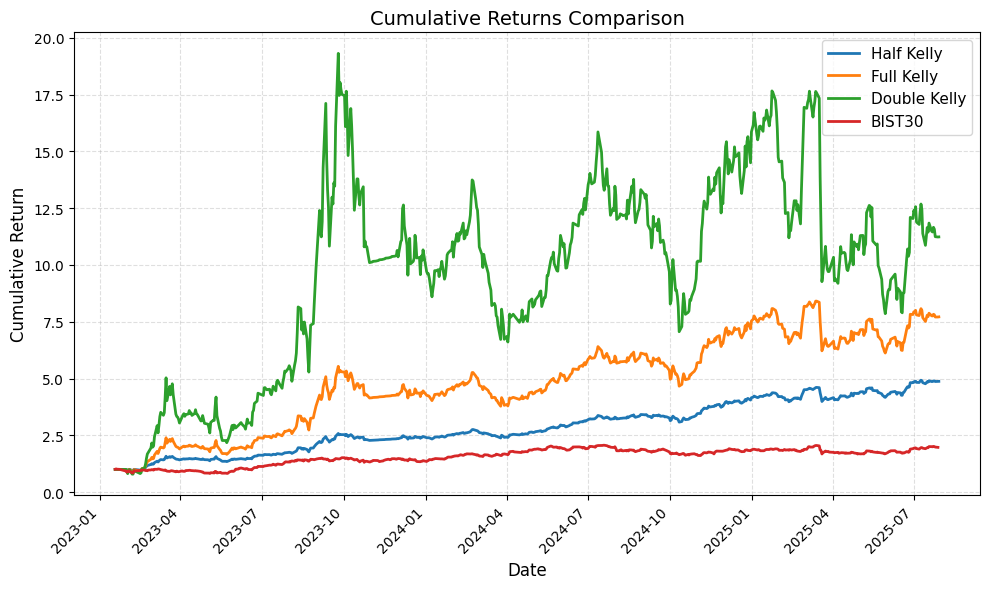

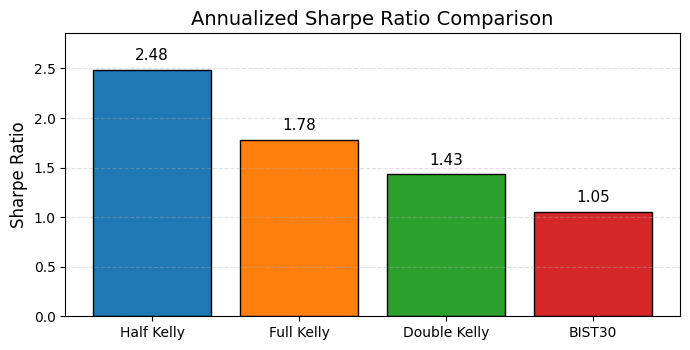

In [ ]:
# stock columns
stock_cols = merged_df.columns.drop("r")

# helper to forward‐fill and compute daily returns
def get_daily_ret(f_df):
    f_df = f_df.copy()
    f_df.columns = stock_cols
    f_daily = f_df.reindex(merged_df.index, method="ffill")
    excess = merged_df[stock_cols].sub(merged_df["r"], axis=0)
    return merged_df["r"] + (f_daily * excess).sum(axis=1)

# full/half/double Kelly daily returns
ret_kelly = get_daily_ret(f_optimum_df)
ret_half = get_daily_ret(f_optimum_df_half_kelly)
ret_double = get_daily_ret(f_optimum_df_double_kelly)

# Define BIST30 benchmark returns and cumulative series
ret_bench = bist30_returns.iloc[:, 0]

cum_kelly = (1 + ret_kelly).cumprod()
cum_half = (1 + ret_half).cumprod()
cum_double = (1 + ret_double).cumprod()
cum_bench = (1 + ret_bench).cumprod()

# Plot cumulative returns ---
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(cum_half,   label="Half Kelly",    linewidth=2)
ax.plot(cum_kelly,  label="Full Kelly",         linewidth=2)
ax.plot(cum_double, label="Double Kelly",  linewidth=2)
ax.plot(cum_bench,  label="BIST30",linewidth=2)

ax.set_title("Cumulative Returns Comparison", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Cumulative Return", fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, linestyle="--", alpha=0.4)
fig.autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()

# Compute and plot annualized Sharpe ratios ---
# Annualized Sharpe = (mean daily ret / std daily ret) * sqrt(252)
names  = ["Half Kelly", "Full Kelly", "Double Kelly", "BIST30"]
values = [
    ret_half.mean()   / ret_half.std()   * np.sqrt(252),
    ret_kelly.mean()  / ret_kelly.std()  * np.sqrt(252),
    ret_double.mean() / ret_double.std() * np.sqrt(252),
    ret_bench.mean()  / ret_bench.std()  * np.sqrt(252),
]

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]


fig, ax = plt.subplots(figsize=(7,4))
bars = ax.bar(names, values, color=colors, edgecolor="black")

ax.set_title("Annualized Sharpe Ratio Comparison", fontsize=14)
ax.set_ylabel("Sharpe Ratio", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.4)

for bar in bars:
    h = bar.get_height()
    ax.annotate(
        f"{h:.2f}",
        xy=(bar.get_x() + bar.get_width() / 2, h),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=11,
        clip_on=False
    )

fig.subplots_adjust(top=0.88)

plt.tight_layout(rect=[0, 0, 1, 0.90])
top_val = max(values)
ax.set_ylim(0, top_val * 1.15)
plt.show()

**Key Takeaways:**
* Half-Kelly tops the list in terms of risk-adjusted return, beating Full and Double Kelly, even the BIST30 benchmark by ~135 bps of Sharpe.
* Full-Kelly also outranks the benchmark but at the expense of higher drawdowns and sharp volatility spikes.
* Double-Kelly maximizes nominal returns but variance rises faster, wearing down its Sharpe ratio.
* Having a daily TLREF rate materially moderates allocations when risk-free yields surge, precluding over-leveraged bets in regimes of high rates.
* A monthly rebalancing cycle attains a reasonable balance: it reacts rapidly to changing regimes of returns without over-trading noise.

**Practitioner Implications:**
* Fractional Kelly (for example, 50%) outperforms Full Kelly under real-world conditions, capping drawdowns and turnover at the expense of coming only marginally short of anticipated growth.
* Dynamic rebalancing with one-month lookback can detect regime shifts in the expected returns as well as in the covariances within the BIST 30 world.
* Anchoring to everyday TLREF creates hedges in a rate-sensitive risk budget, avoiding over-aggressive positioning when rates surge unexpectedly.
* Transaction-cost sensitivity: Monthly rebalancing keeps turnover—and thus trading costs—manageable in real-world use.
* Leverage constraints impose prudence; practitioners can tighten or relax this constraint to get the finest-grained portfolio aggression adjustment in terms of capital limitations.
* The design is model-independent and generalizes well to other fixed-income or emerging-markets universes, provided that you have a good short-term risk-free anchor.
